In [1]:
import hyppo
import numpy as np
from numba import njit
from hyppo.independence.base import IndependenceTest
from hyppo._utils import perm_test
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy 
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from statsmodels.distributions.empirical_distribution import ECDF
from hyppo.sims import *
from hyppo.ksample._utils import k_sample_transform

In [3]:
from benchmarks import power_2samp_sample
from hyppo.independence import CCA, Dcorr, HHG, Hsic, RV, MGC
from hyppo.sims import *

import sys
sys.executable
sys.path
#sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')
#sys.path.append('C:\\Users\\siptest\\Desktop\\R-3.6.2\\bin\\x64')

import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

In [5]:
class UF(IndependenceTest): 
    def _init_(self, compute_distance='euclidean', bias = False, **kwargs): 
        self._name_= "UF"
        IndepedenceTest._init_(self)
        
    def uf(self, X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
        
        # Build forest with default parameters.
        model = BaggingClassifier(DecisionTreeClassifier(), 
                                  n_estimators=n_estimators, 
                                  max_samples=max_samples, 
                                  bootstrap=False)
        model.fit(X, y)
        n = X.shape[0]
        K = model.n_classes_
        _, y = np.unique(y, return_inverse=True)
        
        cond_entropy = 0
        for tree_idx, tree in enumerate(model):
            # Find the indices of the training set used for partition.
            sampled_indices = model.estimators_samples_[tree_idx]
            unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
            
            # Randomly split the rest into voting and evaluation.
            total_unsampled = len(unsampled_indices)
            np.random.shuffle(unsampled_indices)
            vote_indices = unsampled_indices[:total_unsampled//2]
            eval_indices = unsampled_indices[total_unsampled//2:]
            
            # Store the posterior in a num_nodes-by-num_classes matrix.
            # Posteriors in non-leaf cells will be zero everywhere
            # and later changed to uniform.
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            est_nodes = tree.apply(X[vote_indices])
            est_classes = y[vote_indices]
            for i in range(len(est_nodes)):
                class_counts[est_nodes[i], est_classes[i]] += 1
            
            row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
            row_sums[row_sums == 0] = 1 # Avoid divide by zero.
            class_probs = class_counts / row_sums[:, None]
            
            # Make the nodes that have no estimation indices uniform.
            # This includes non-leaf nodes, but tha t will not affect the estimate.
            class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
            # Apply finite sample correction and renormalize.
            where_0 = np.argwhere(class_probs == 0)
            for elem in where_0:
                class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
            row_sums = class_probs.sum(axis=1)
            class_probs = class_probs / row_sums[:, None]
            
            # Place evaluation points in their corresponding leaf node.
            # Store evaluation posterior in a num_eval-by-num_class matrix.
            eval_class_probs = class_probs[tree.apply(X[eval_indices])]
            # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
            eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
            cond_entropy += np.mean(eval_entropies)
    
          
        return cond_entropy / n_estimators
    
    def _statistic(self, X, y): 
        stat = self.uf(X, y)
        self.stat = stat
        return stat
    #def test(self, X, y): 
        #return self.perm_test(X, y)
    def test(self, X, y, reps = 100, workers = -1):
        stat, pvalue, _ = perm_test(self._statistic, X, y, reps = reps, is_distsim=True)
        self.stat = stat
        self.pvalue = pvalue
        
        return stat, pvalue

In [6]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 20
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
#POWER_REPS = 5
POWER_REPS = 1 

SIMULATIONS = [
    #"linear": "Linear",
    #"multimodal_independence": "Independence"
    linear, 
    multimodal_independence
]

TESTS = [
    UF, 
]

In [7]:
def estimate_power(sim, test):
    #est_power = np.array([np.mean([power_2samp_sample(test, trans_2samp, sim, n=i) for _ in range(POWER_REPS)])
                          #for i in SAMP_SIZES])
    est_power = []
    for i in SAMP_SIZES: 
        power = np.mean([power_2samp_sample(test, trans_2samp, sim, n=i, reps = 100, workers = 1) for _ in range(POWER_REPS)])
        est_power.append(power)
        np.savetxt('C:/Users/siptest/Desktop/NDD/{}_{}2.csv'.format(sim.__name__, "UF"),
               est_power, delimiter=',')
    
    return est_power

In [8]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in SIMULATIONS for test in TESTS]
)
#outputs = []
#for test in TESTS: 
    #for sim in SIMULATIONS:
        #estimate_power(sim, test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 506.3min
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 516.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 516.5min finished


In [9]:
def plot_power(): 
    fig, ax = plt.subplots(nrows = 1, ncols =2, figsize = (28, 24))
    
    sim_title = [
        "Linear", 
        "Independence"
    ]
    
    for i, col in enumerate(ax):
        sim = SIMULATIONS[i]
        for test in TESTS:
                power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/{}_{}2.csv'.format(sim.__name__, "UF"),
                                      delimiter=',')
        col.plot(SAMP_SIZES, power, label="UF", lw=1)
        col.set_xticks([])
        col.set_yticks([-1, 0, 1])
        col.set_title(sim_title[i])
    fig.text(0.5, 0.08, 'Sample Size', ha='center')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.08), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('C:/Users/siptest/Desktop/NDD/2samp_power_indep2.png', transparent=True, bbox_inches='tight')

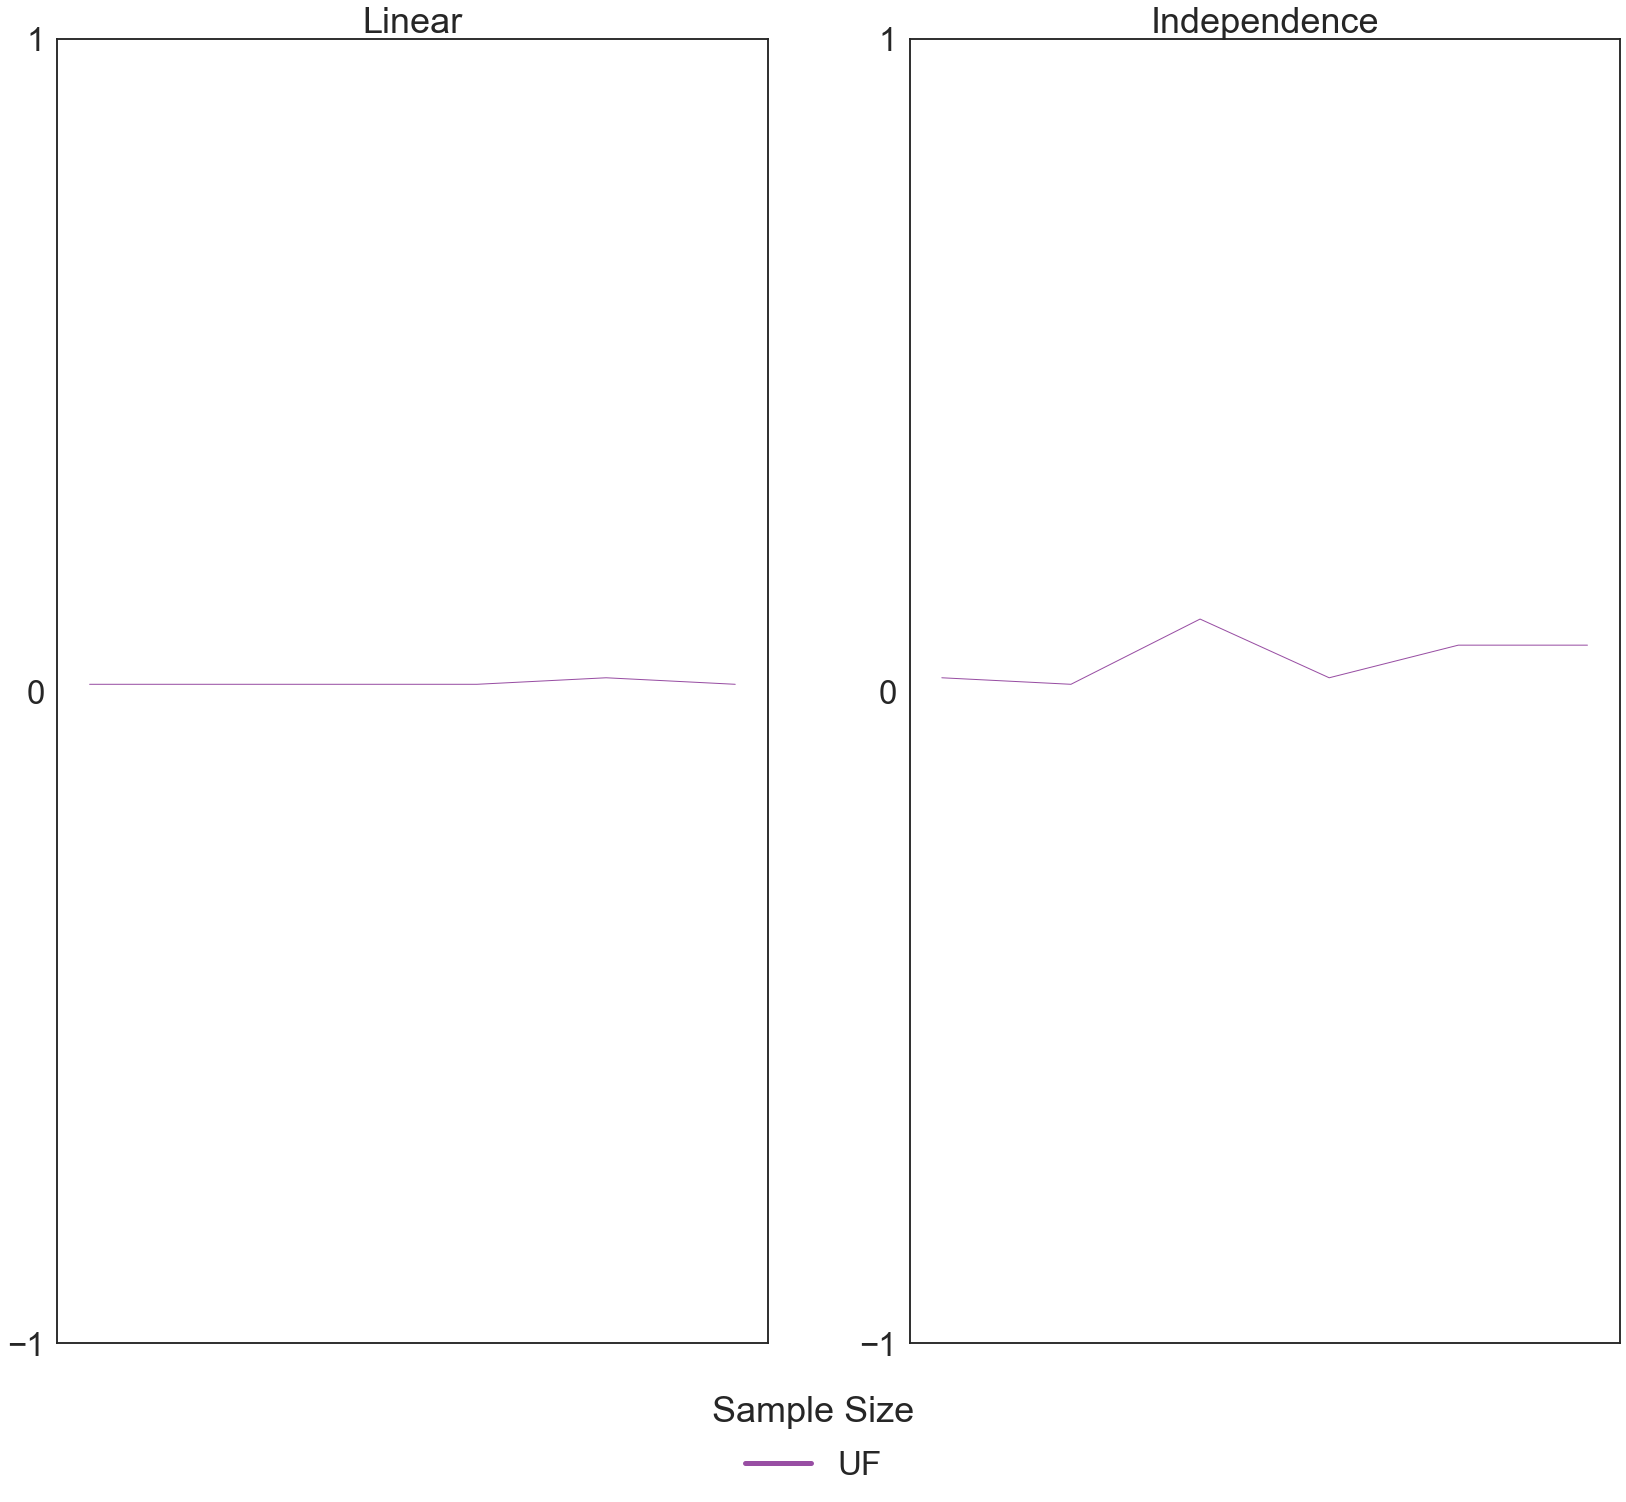

In [10]:
plot_power()